# LAB 4 PT.1: JPEG COMPRESSION

![Screenshot from 2023-12-06 19-13-51.png](<attachment:Screenshot from 2023-12-06 19-13-51.png>)
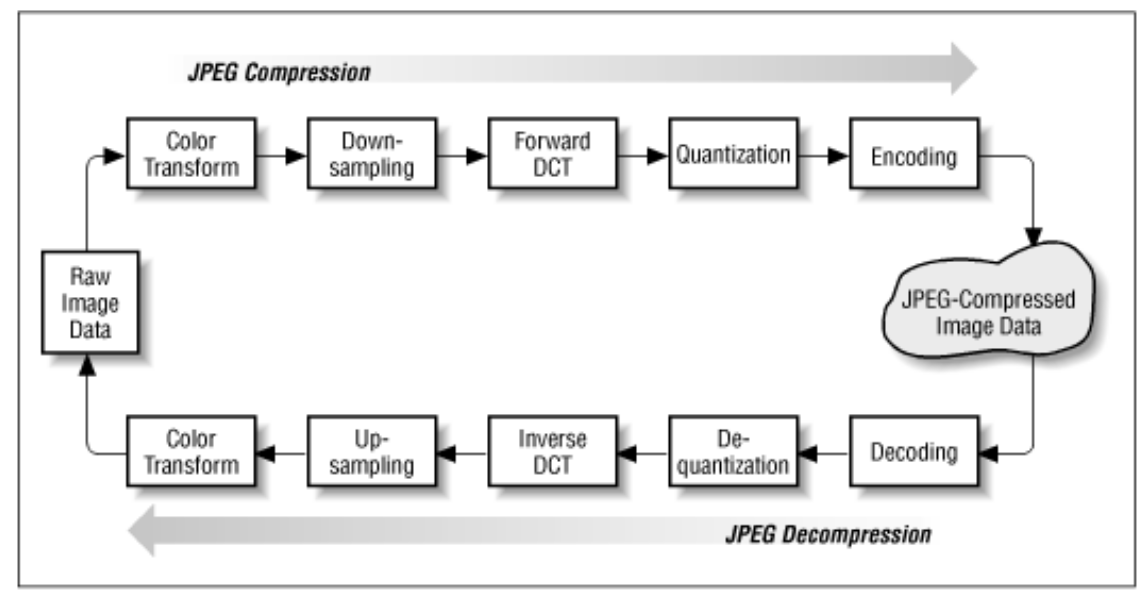

## Color Transform

In [1]:
# python 3.9.5
from math import ceil

import cv2
import numpy as np

from JPEGImageCompressormain.functions import *

# define quantization tables
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])
# define window size
windowSize = len(QTY)

# read image
imgOriginal = cv2.imread('JPEGImageCompressormain/marbles.bmp', cv2.IMREAD_COLOR)
# convert BGR to YCrCb
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCR_CB)
width = len(img[0])
height = len(img)
y = np.zeros((height, width), np.float32) + img[:, :, 0]
cr = np.zeros((height, width), np.float32) + img[:, :, 1]
cb = np.zeros((height, width), np.float32) + img[:, :, 2]
# size of the image in bits before compression
totalNumberOfBitsWithoutCompression = len(y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8
# channel values should be normalized, hence subtract 128
y = y - 128
cr = cr - 128
cb = cb - 128

## Downsampling

In [2]:
# 4: 2: 2 subsampling is used # another subsampling scheme can be used
# thus chrominance channels should be sub-sampled
# define subsampling factors in both horizontal and vertical directions
SSH, SSV = 2, 2
# filter the chrominance channels using a 2x2 averaging filter # another type of filter can be used
crf = cv2.boxFilter(cr, ddepth=-1, ksize=(2, 2))
cbf = cv2.boxFilter(cb, ddepth=-1, ksize=(2, 2))
crSub = crf[::SSV, ::SSH]
cbSub = cbf[::SSV, ::SSH]

# check if padding is needed,
# if yes define empty arrays to pad each channel DCT with zeros if necessary
yWidth, yLength = ceil(len(y[0]) / windowSize) * windowSize, ceil(len(y) / windowSize) * windowSize
if (len(y[0]) % windowSize == 0) and (len(y) % windowSize == 0):
    yPadded = y.copy()
else:
    yPadded = np.zeros((yLength, yWidth))
    for i in range(len(y)):
        for j in range(len(y[0])):
            yPadded[i, j] += y[i, j]

# chrominance channels have the same dimensions, meaning both can be padded in one loop
cWidth, cLength = ceil(len(cbSub[0]) / windowSize) * windowSize, ceil(len(cbSub) / windowSize) * windowSize
if (len(cbSub[0]) % windowSize == 0) and (len(cbSub) % windowSize == 0):
    crPadded = crSub.copy()
    cbPadded = cbSub.copy()
# since chrominance channels have the same dimensions, one loop is enough
else:
    crPadded = np.zeros((cLength, cWidth))
    cbPadded = np.zeros((cLength, cWidth))
    for i in range(len(crSub)):
        for j in range(len(crSub[0])):
            crPadded[i, j] += crSub[i, j]
            cbPadded[i, j] += cbSub[i, j]

## Forward DCT and Quantization


In [3]:
# get DCT of each channel
# define three empty matrices
yDct, crDct, cbDct = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))

# number of iteration on x axis and y axis to calculate the luminance cosine transform values
hBlocksForY = int(len(yDct[0]) / windowSize)  # number of blocks in the horizontal direction for luminance
vBlocksForY = int(len(yDct) / windowSize)  # number of blocks in the vertical direction for luminance
# number of iteration on x axis and y axis to calculate the chrominance channels cosine transforms values
hBlocksForC = int(len(crDct[0]) / windowSize)  # number of blocks in the horizontal direction for chrominance
vBlocksForC = int(len(crDct) / windowSize)  # number of blocks in the vertical direction for chrominance

# define 3 empty matrices to store the quantized values
yq, crq, cbq = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))
# and another 3 for the zigzags
yZigzag = np.zeros(((vBlocksForY * hBlocksForY), windowSize * windowSize))
crZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))
cbZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))

for i in range(vBlocksForY):
    for j in range(hBlocksForY):
        yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            yPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTY)
        yZigzag[i * j] += zigzag(
            yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
yZigzag = yZigzag.astype(np.int16)

# either crq or cbq can be used to compute the number of blocks
for i in range(vBlocksForC):
    for j in range(hBlocksForC):
        crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            crPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC)
        crZigzag[i * j] += zigzag(
            crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            cbPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
            cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC)
        cbZigzag[i * j] += zigzag(
            cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
crZigzag = crZigzag.astype(np.int16)
cbZigzag = cbZigzag.astype(np.int16)

## Encoding

In [4]:
# find the run length encoding for each channel
# then get the frequency of each component in order to form a Huffman dictionary
yEncoded = run_length_encoding(yZigzag)
yFrequencyTable = get_freq_dict(yEncoded)
yHuffman = find_huffman(yFrequencyTable)

crEncoded = run_length_encoding(crZigzag)
crFrequencyTable = get_freq_dict(crEncoded)
crHuffman = find_huffman(crFrequencyTable)

cbEncoded = run_length_encoding(cbZigzag)
cbFrequencyTable = get_freq_dict(cbEncoded)
cbHuffman = find_huffman(cbFrequencyTable)

# calculate the number of bits to transmit for each channel
# and write them to an output file
file = open("CompressedImage.asfh", "w")
yBitsToTransmit = str()
for value in yEncoded:
    yBitsToTransmit += yHuffman[value]

crBitsToTransmit = str()
for value in crEncoded:
    crBitsToTransmit += crHuffman[value]

cbBitsToTransmit = str()
for value in cbEncoded:
    cbBitsToTransmit += cbHuffman[value]

if file.writable():
    file.write(yBitsToTransmit + "\n" + crBitsToTransmit + "\n" + cbBitsToTransmit)
file.close()

totalNumberOfBitsAfterCompression = len(yBitsToTransmit) + len(crBitsToTransmit) + len(cbBitsToTransmit)
print(
    "Compression Ratio is " + str(
        np.round(totalNumberOfBitsWithoutCompression / totalNumberOfBitsAfterCompression, 1)))

Compression Ratio is 15.3


## Are you able to decode?

In [5]:
#TRY IT!

# Quantization table

In [6]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import struct

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)


# Load an image
image_path = "IMG_3709.JPG"

# Read the image
image_rgb = Image.open(image_path)
y_quantization_table = np.reshape(image_rgb.quantization[0], (8,8))
cbcr_quantization_table = np.reshape(image_rgb.quantization[1], (8,8))

print('Y quantization table: ')
print(y_quantization_table)
print('\n CBCR quantization table: ')
print(cbcr_quantization_table)

Y quantization table: 
[[ 2  2  3  4  5  6  8 11]
 [ 2  2  2  4  5  7  9 11]
 [ 3  2  3  5  7  9 11 12]
 [ 4  4  5  7  9 11 12 12]
 [ 5  5  7  9 11 12 12 12]
 [ 6  7  9 11 12 12 12 12]
 [ 8  9 11 12 12 12 12 12]
 [11 11 12 12 12 12 12 12]]

 CBCR quantization table: 
[[ 3  3  7 13 15 15 15 15]
 [ 3  4  7 13 14 12 12 12]
 [ 7  7 13 14 12 12 12 12]
 [13 13 14 12 12 12 12 12]
 [15 14 12 12 12 12 12 12]
 [15 12 12 12 12 12 12 12]
 [15 12 12 12 12 12 12 12]
 [15 12 12 12 12 12 12 12]]


# Why Quantization Table is so important?

It can be used for forensics purpose to understand on which social network an image was shared.

![Screenshot from 2023-12-06 19-27-27.png](<attachment:Screenshot from 2023-12-06 19-27-27.png>)
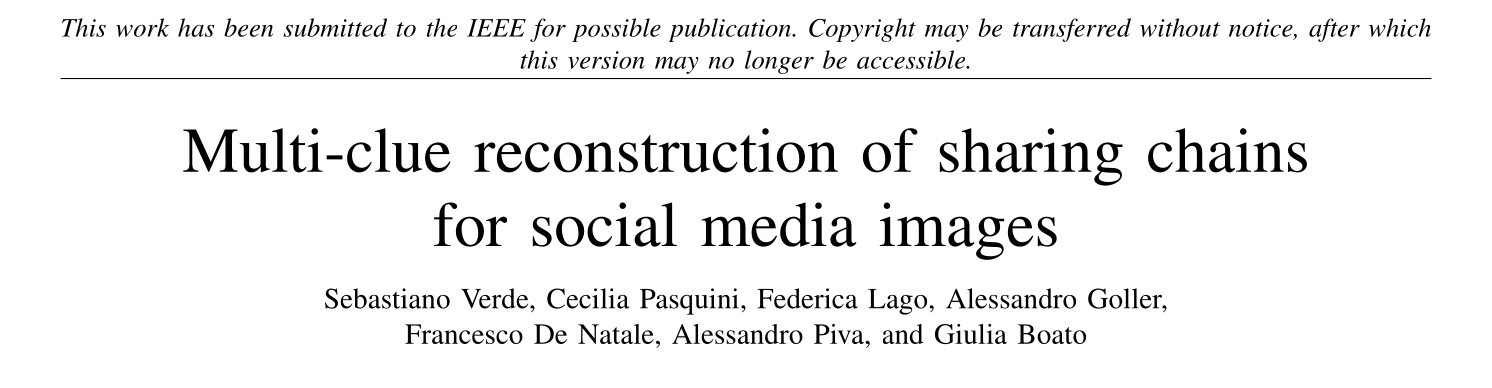

# Exercise 1: Understanding Color Channels
Open an image, display the image and identify the color channels (e.g., Y, Cb, Cr).
Write a function to separate the image into its color channels.
Apply a compression technique (downsample the color channel) 
Display the compressed image and compare it with the original.

(560, 300)
(560, 300)
(560, 300)


Text(0.5, 1.0, 'Compressed Image')

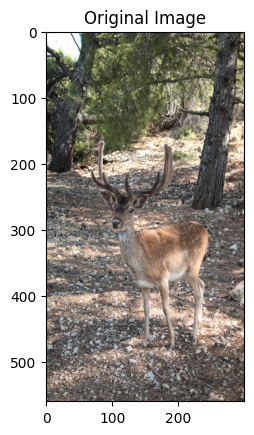

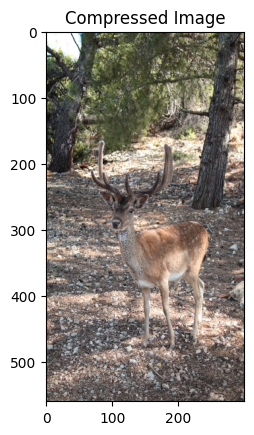

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image_path = "IMG_3709.JPG"
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (300, 560))
ycbcr_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2YCR_CB)

# Separate into color channels
y, cr, cb = cv2.split(ycbcr_img)

crf = cv2.boxFilter(cr, ddepth=-1, ksize=(2, 2))
cbf = cv2.boxFilter(cb, ddepth=-1, ksize=(2, 2))
crSub = crf[::4, ::4]
cbSub = cbf[::4, ::4]

cr_comp = cv2.resize(crSub, (300, 560))
cb_comp = cv2.resize(cbSub, (300, 560))
print(np.shape(y))
print(np.shape(cr_comp))
print(np.shape(cb_comp))
# Merge compressy_quantization_tableed channels
compressed_image = cv2.merge([y, cr_comp, cb_comp])

# Display images
plt.figure()
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.figure()
plt.imshow(cv2.cvtColor(compressed_image, cv2.COLOR_YCR_CB2RGB))
plt.title("Compressed Image")


# Exercise 2: Implementing DCT Compression
Load an image, implement the 2D Discrete Cosine Transform (DCT) for an 8x8 block of pixels.
Apply the DCT to non-overlapping 8x8 blocks of the image.
Implement a compression strategy by quantizing the DCT coefficients.
Reconstruct the image using the inverse DCT (IDCT).
Display the compressed and reconstructed image.
Experiment with different quantization tables and observe the impact on image quality.

Text(0.5, 1.0, 'Compressed Image')

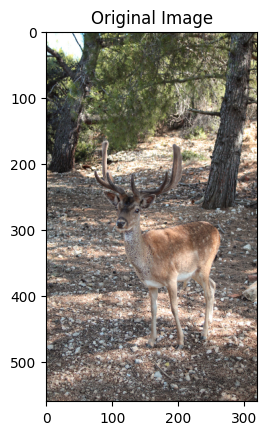

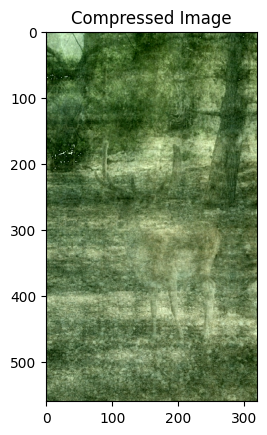

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dct_compress(img_channel, channel, skip=False):
    
    
    # Apply DCT to 8x8 blocks
    dct_image = cv2.dct(np.float32(img_channel))
    if not skip:
        if channel == 'y':
            # Apply quantization (example: use a simple quantization matrix)
            quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])
        else:
            quantization_matrix = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])
        

        quantized_dct = np.zeros_like(dct_image)


        for i in range(0, original_image.shape[0], 8):
            for j in range(0, original_image.shape[1], 8):
                block = dct_image[i:i+8, j:j+8]
                quantized_block = np.round(block / quantization_matrix)
                quantized_dct[i:i+8, j:j+8] = quantized_block

        # Reconstruct image using inverse DCT
        reconstructed_image = cv2.idct(quantized_dct)       
    else:
        reconstructed_image = cv2.idct(quantized_dct)
    return reconstructed_image

# Load an imagey_quantization_table
image_path = "IMG_3709.JPG"
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (320, 560))
ycbcr_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2YCR_CB)

y, cr, cb = cv2.split(ycbcr_img)


y_comp = dct_compress(y, 'y')
cr_comp = dct_compress(cr, 'c')
cb_comp = dct_compress(cb, 'c')

reconstructed_image = cv2.merge([y_comp, cr_comp, cb_comp])


# Display images
plt.figure()
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.figure()
plt.imshow(cv2.cvtColor(np.uint8((reconstructed_image/np.max(reconstructed_image)*255)), cv2.COLOR_YCR_CB2RGB))
plt.title("Compressed Image")


# Exercise 3: Extracting Quantization Tables
Explore image metadata to find information about quantization tables.
Implement a function to display or print the extracted quantization tables.
Modify the quantization tables and observe the impact on the compressed image.
Compare the quality of the compressed image using different quantization tables.


In [88]:
import cv2

# Load an image
image_path = "IMG_3709.JPG"
image = cv2.imread(image_path)

